In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [1]:
import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

from fno_utils import FNO2d, FNODatasetSingle

In [2]:
device = "cuda"

cfg_fn = os.path.join("experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [3]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [4]:
def c2_metric(field):
    # axes here are specified assuming data is [batch, dim_x, dim_y], i.e. batch of 2D scalar fields
    grad_x, grad_y   = np.gradient(field, axis=(-2,-1))
    grad_xx, grad_xy = np.gradient(grad_x, axis=(-2,-1))
    grad_yx, grad_yy = np.gradient(grad_y, axis=(-2,-1))

    subnorms = np.array([
        np.max(np.abs(field), axis=(-2,-1)), 
        np.max(np.abs(np.array([grad_x, grad_y])), axis=(0,-2,-1)),
        np.max(np.abs(np.array([grad_xx, grad_xy, grad_yx, grad_yy])), axis=(0,-2,-1)),
    ]).T
    return subnorms[:,0] + np.max(subnorms[:,:2], axis=1) / 2 + np.max(subnorms[:, :3], axis=1) / 4

In [5]:
scores = []
downsampling = [1,2,4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

    #     diff        = (yyhat[...,0,0] - yybatch[...,0,0]).cpu().detach().numpy()
    #     score_batch = c2_metric(diff)
    #     res_scores.append(score_batch)
    # scores.append(np.concatenate(res_scores))

.H5 file extension is assumed hereafter


In [9]:
sample = yyhat[...,0,0].cpu().detach().numpy()

In [10]:
from findiff import FinDiff

_, dy, dx = 1 / np.array(sample.shape)

partials_fields = [np.array([sample])]
for m in range(1,4):
    perms = []
    for i in range(m + 1):
        perms.append([i, m-i]) # hardcoded for 2D for now, but 3D extension is fairly straightforward
    
    alphas = []
    for perm in perms:
        alpha = []
        if perm[0] != 0:
            alpha.append((1, dx, perm[0]))
        if perm[1] != 0:
            alpha.append((2, dy, perm[1]))
        alphas.append(alpha)
    
    alpha_partials_field = np.array([FinDiff(*alpha)(sample) for alpha in alphas])
    partials_fields.append(alpha_partials_field)
partial_field_maxes = np.array([np.max(partial_field, axis=(0,2,3)) for partial_field in partials_fields])
norms = np.sum(partial_field_maxes, axis=0)

In [11]:
norms.shape

(25,)

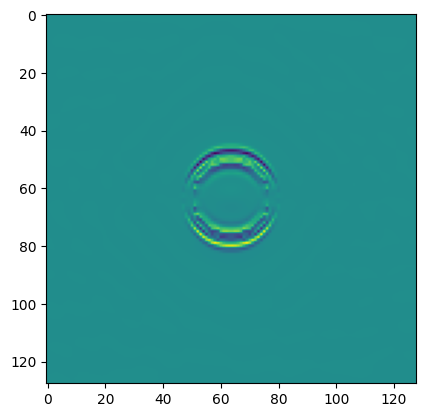

In [117]:
plt.imshow(derivative_fields[3][3])

In [108]:
grad_x, grad_y   = np.gradient(sample, axis=(-2,-1))

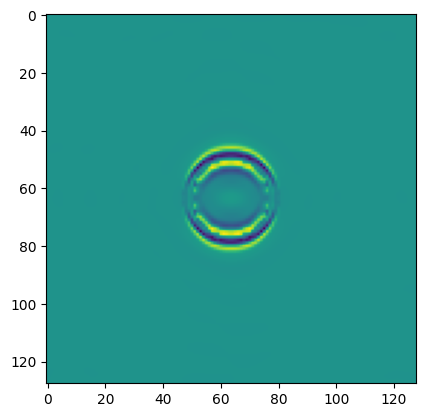

In [112]:
plt.imshow(grad_xx)

In [22]:
sns.set_theme()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [23]:
alphas = np.arange(0, 1, 0.05)
fake_cov = 1 - alphas + 0.01 * np.random.random(alphas.shape)

In [60]:
res_to_cov = dict(zip([r"$128\times 128$", r"$64\times 64$", r"$32\times 32$"], [alphas + 0.01 * np.random.random(alphas.shape) for _ in range(3)]))
df = pd.DataFrame.from_dict(res_to_cov)
df[r"$\alpha$"] = alphas

sns.lineplot(df, palette="flare")
plt.xlabel(r"$\mathrm{Expected\ Coverage}\ (1-\alpha)$")
plt.ylabel(r"$\mathrm{Empirical\ Coverage}$")
plt.title(r"$\mathrm{" + pde_name + r"}$")

Text(0.5, 1.0, '$\\mathrm{2D_rdb_NA_NA}$')

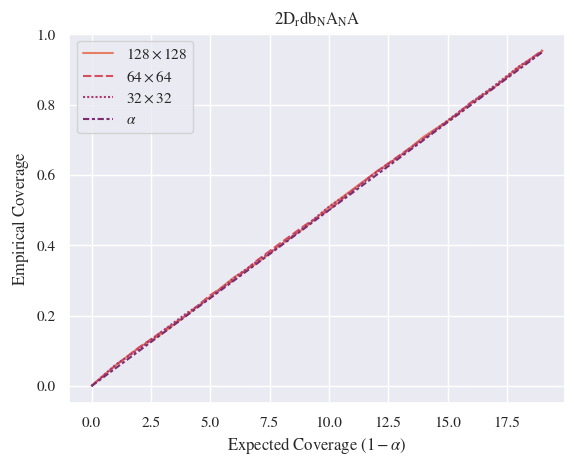

In [62]:
sns.lineplot(df, palette="flare")
plt.xlabel(r"$\mathrm{Expected\ Coverage}\ (1-\alpha)$")
plt.ylabel(r"$\mathrm{Empirical\ Coverage}$")
plt.title(r"$\mathrm{" + pde_name + r"}$")

/tmp/ipykernel_753892/2880358334.py:6: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(x=(1-alphas), y=fake_cov, hue=res, label="$\mathrm{" + resolution + "}$", palette=palette)


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

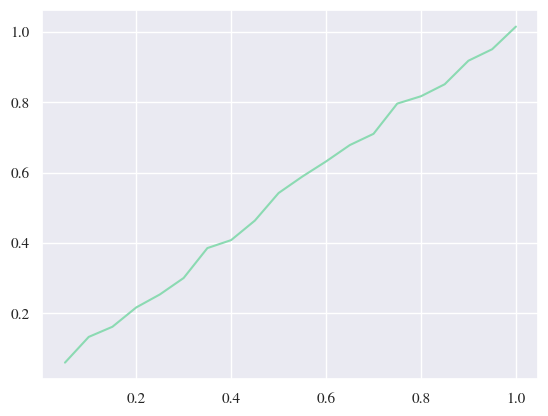

In [27]:
palette = sns.color_palette("mako_r", 6)

for res, resolution in zip([128,64,32], [r"128\times 128", r"64\times 64", r"32\times 32"]):
    alphas = np.arange(0, 1, 0.05)
    fake_cov = 1 - alphas + 0.05 * np.random.random(alphas.shape)
    sns.lineplot(x=(1-alphas), y=fake_cov, hue=res, label="$\mathrm{" + resolution + "}$", palette=palette)
# sns.lineplot(x=(1-alphas), y=(1-alphas), linestyle='--')
plt.xlabel(r"$\mathrm{Expected\ Coverage}\ (1-\alpha)$")
plt.ylabel(r"$\mathrm{Empirical\ Coverage}$")
plt.title(r"$\mathrm{" + pde_name + r"}$")